In [27]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
import contextily as cx
import numpy as np
import joblib

In [ ]:
from pyrosm import OSM, get_data

osm_fp = "./openstreetmap data/porto.osm.pbf"
# We will use test data for Helsinki that comes with pyrosm
osm = OSM(osm_fp)

# Parse roads that can be driven by car
roads = osm.get_network(network_type="driving")
roads.plot(figsize=(10,10))

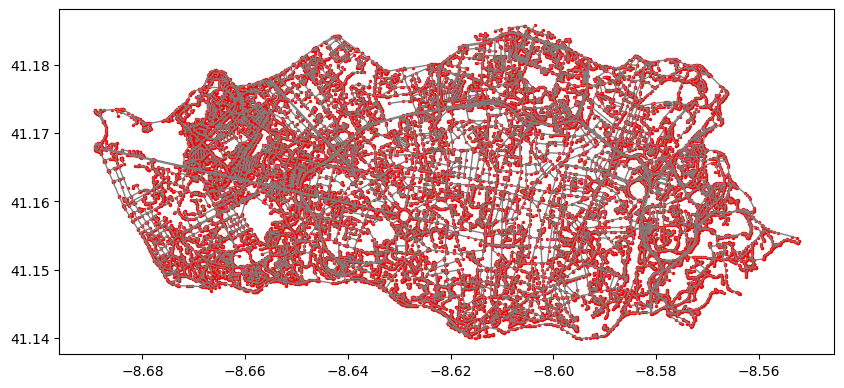

In [3]:
# Parse nodes and edges
road_nodes, road_edges = osm.get_network(network_type="driving", nodes=True)

# Plot the data
ax = road_edges.plot(figsize=(10,10), color="gray", lw=1.0)
ax = road_nodes.plot(ax=ax, color="red", markersize=2)

In [7]:
data_folder = "./openstreetmap data/"
stcp_nodes = gpd.read_file(data_folder + "stcp_nodes.gpkg")
stcp_edges = gpd.read_file(data_folder + "stcp_edges.gpkg")
metro_nodes = gpd.read_file(data_folder + "metro_nodes.gpkg")
metro_edges = gpd.read_file(data_folder + "metro_edges.gpkg")

stcp_nodes.crs = "EPSG:4326"
stcp_edges.crs = "EPSG:4326"

G = osm.to_graph(stcp_nodes, stcp_edges, graph_type="networkx")

In [11]:
ox.plot_graph_folium(G)


C:\Users\jcarv\AppData\Local\Temp\ipykernel_7620\4128721249.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_graph_folium(G)


In [12]:
# Origin
orig_address = "Av. da Boavista 604-610, 4149-071 Porto"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Rua D. Frei Vicente da Soledade e Castro, Porto"
dest_y, dest_x = ox.geocode(dest_address) 

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: -8.6307703 41.1590784
Destination coords: -8.598334783806017 41.1776997243421


In [13]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(G, X=dest_x, Y=dest_y, return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: BCM4 and distance: 51.74511646938983 meters.
Destination node-id: FEUP2 and distance: 157.7244153477641 meters.


In [ ]:
# Calculate the paths
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length')
time_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

# Get also the actual travel times (summarize)
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')
travel_time = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

In [ ]:
fig, ax = ox.plot_graph_route(G, metric_path)  # ou time_path

# Add the travel time as title
ax.set_xlabel("Shortest path distance {t: .1f} meters.".format(t=travel_length))

In [ ]:
ox.plot_route_folium(G, metric_path)  # visualização diferente da mesma coisa


In [22]:
sections = gpd.read_file(data_folder + "sections.gpkg")
# sections.crs = "EPSG:4326"

# sections.geometry = sections.geometry.centroid
# rename column DTMNFRSEC21 to id
sections.rename(columns={'DTMNFRSEC21': 'id'}, inplace=True)

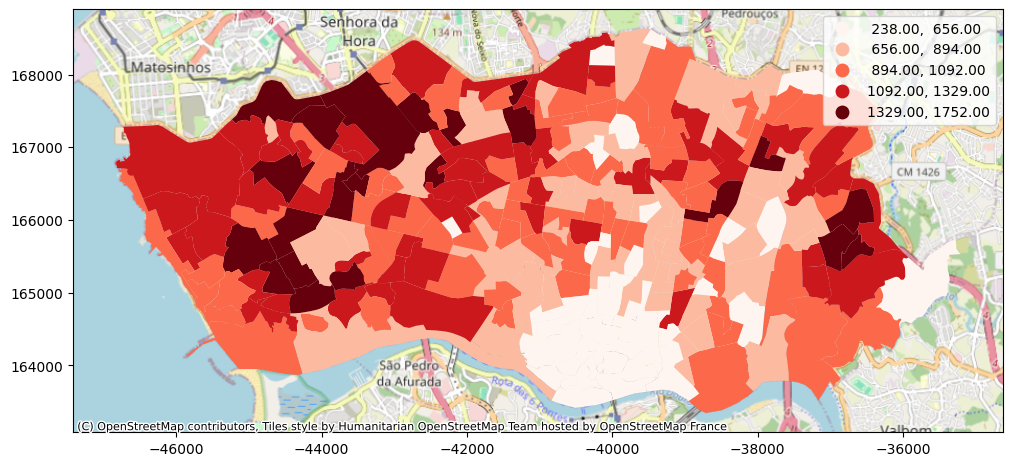

In [23]:
ax = sections.plot("N_INDIVIDUOS", scheme="natural_breaks", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
cx.add_basemap(ax, crs=sections.crs)

In [28]:
# matrix = pd.DataFrame({'from_id': sections['id'].values.repeat(len(sections)), 'to_id': np.tile(sections['id'].values, len(sections))})
# ...

matrix = joblib.load(data_folder + 'matrix.pkl')

In [ ]:
matrix

metric_path é de ter corrido o djikstra entre todos os nós e guardado o caminho mais curto entre cada par de nós (demorou 6 horas e o topo da rede estava cortada/interrompida)

metric_path2 é de ter corrido o floyd_warshall e guardado o caminho mais curto entre cada par de nós
(demorou menos de 10 minutos)

In [ ]:
sections_nearest = sections.copy()
sections_nearest['nearest_node'] = sections.apply(lambda x: ox.distance.nearest_nodes(G, x.geometry.centroid.x, x.geometry.centroid.y), axis=1)

In [ ]:
# demora uns 5 min a correr

floyd_predecessors, floyd_distances = nx.floyd_warshall_predecessor_and_distance(G, weight='length')